# Logistic regression

For each word count how many times it is used in good and bad jokes (positive and negative frequency). For each joke some up this frequencies for all words (except stop words). Use logistic regression to classify jokes based on these features.

In [45]:
import sys
if '..' not in sys.path:
    sys.path.append('..')
from src.utils import tokenize, lemmatize, LoadIndices, LoadDatasets

import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("russian"))

from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load datasets
an_good, an_bad, bash_good, bash_bad = LoadDatasets()

# Load direct and inverted indices
an_good_direct, an_bad_direct, an_good_inverted, an_bad_inverted, \
bash_good_direct, bash_bad_direct, bash_good_inverted, bash_bad_inverted = LoadIndices()

## Anecdotes classification

In [101]:
# Train and test samples indices
N = len(an_good_direct)

def TrainTestIdx(N, train_share = 0.75):
    N_train = int(train_share * N)
    N_test = N - N_train
    idx = np.arange(N)
    np.random.shuffle(idx)  # random indices
    idx_train = idx[:N_train]  # Number of train samples from good and bad sets (total number is 2*N_train)
    idx_test = idx[N_train:]
    return idx_train, idx_test

idx_train, idx_test = TrainTestIdx(N)

# How many times each word met in good and jokes
def getFreq(direct_index, idx):
    freq = {}
    for i in idx:
        d = direct_index[i]
        for w in d:
            if w not in stopwords:
                freq[w] = freq.get(w, 0) + d[w]
    return freq

freq_good = getFreq(an_good_direct, idx_train)
freq_bad = getFreq(an_bad_direct, idx_train)

def ModelData(idx, data = 'anec'):
    if data == 'anec':
        good_direct, bad_direct = an_good_direct, an_bad_direct
    else:
        if data == 'bash':
            good_direct, bad_direct = bash_good_direct, bash_bad_direct
        else:
            print("Unknown data: {}".format(data))
            return
    Nd = len(idx)
    X = np.zeros((2*Nd, 3))
    X[:,0] = 1
    for n in range(Nd):
        i = idx[n]
        for w in good_direct[i]:
            X[n,1] += freq_good.get(w, 0)
            X[n,2] += freq_bad.get(w, 0)
        for w in bad_direct[i]:
            X[Nd+n,1] += freq_good.get(w, 0)
            X[Nd+n,2] += freq_bad.get(w, 0)
    y = np.zeros(2*Nd)
    y[:Nd] = 1    
    return X, y

X, y = ModelData(idx_train, 'anec')

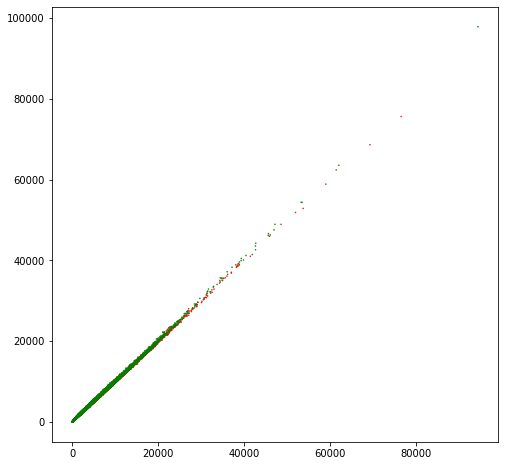

In [102]:
fig = plt.figure(figsize = (8,8))
colors = ['green', 'red']
plt.scatter(X[:,1], X[:,2], c = [colors[int(k)] for k in y], s = 0.3)

In [103]:
lr = LogisticRegression(penalty = 'none')
lr.fit(X, y)
print("Train accuracy: {:.3f}".format(lr.score(X, y)))

Xtest, y_test = ModelData(idx_test, 'anec')
print("Test accuracy: {:.3f}".format(lr.score(Xtest, y_test)))

Train accuracy: 0.569
Test accuracy: 0.513


## Bash quotes classification

In [104]:
# Train and test samples indices
N = len(bash_good_direct)
idx_train, idx_test = TrainTestIdx(N)

freq_good = getFreq(bash_good_direct, idx_train)
freq_bad = getFreq(bash_bad_direct, idx_train)

X, y = ModelData(idx_train, 'bash')

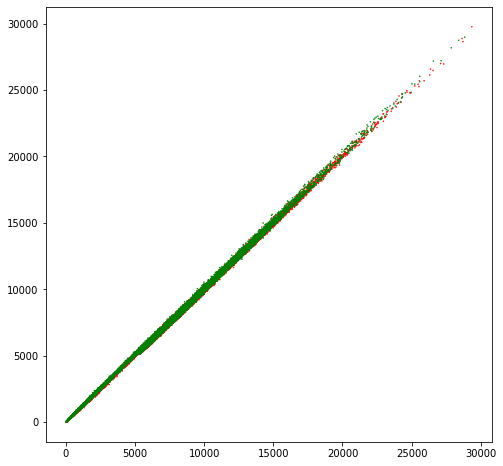

In [105]:
fig = plt.figure(figsize = (8,8))
colors = ['green', 'red']
plt.scatter(X[:,1], X[:,2], c = [colors[int(k)] for k in y], s = 0.3)

In [106]:
lr = LogisticRegression(penalty = 'none')
lr.fit(X, y)
print("Train accuracy: {:.3f}".format(lr.score(X, y)))

Xtest, y_test = ModelData(idx_test, 'bash')
print("Test accuracy: {:.3f}".format(lr.score(Xtest, y_test)))

Train accuracy: 0.573
Test accuracy: 0.501
